<a href="https://colab.research.google.com/github/pooja251096/Cardiovascular-Risk-Prediction/blob/main/Pooja_AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
!pip install CatBoost
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score

     |████████████████████████████████| 76.3 MB 46 kB/s 


In [3]:
# mount drive and give path of dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Classification_cardiovascular/data_cardiovascular_risk.csv")

In [5]:
##View first five rows of the dataframe
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1507,1507,36,1.0,M,NO,0.0,0.0,0,1,0,182.0,145.0,102.0,30.92,72.0,70.0,0
2576,2576,39,1.0,F,NO,0.0,0.0,0,0,0,153.0,107.0,82.0,20.99,75.0,82.0,0
2524,2524,67,1.0,F,NO,0.0,0.0,0,0,0,302.0,121.0,83.0,30.12,75.0,64.0,0
2712,2712,38,2.0,F,YES,5.0,0.0,0,0,0,193.0,107.0,73.0,20.73,85.0,72.0,0
2208,2208,48,3.0,F,NO,0.0,0.0,0,0,0,231.0,131.0,80.0,21.14,70.0,85.0,0


In [6]:
##View last five rows of the dataframe
data.tail()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3385,3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0
3389,3389,54,3.0,F,NO,0.0,0.0,0,0,0,288.0,124.0,77.0,29.88,79.0,92.0,0


In [7]:
data.shape

(3390, 17)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

#Data Cleaning

In [94]:
## Null value checks
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

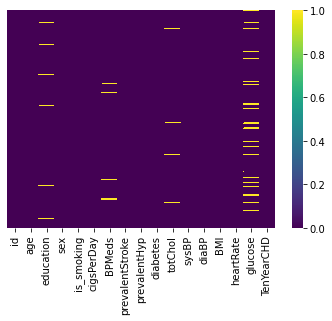

In [95]:
## Null values
sns.heatmap(data.isnull(), yticklabels=False, cmap="viridis")

Dealing with null values

In [96]:
##Impute Missing values with Median. 
data['glucose'] = data['glucose'].fillna(data['glucose'].median())
data['BPMeds'] = data['BPMeds'].fillna(data['BPMeds'].median())
data['heartRate'] = data['heartRate'].fillna(data['heartRate'].median())
data['BMI'] = data['BMI'].fillna(data['BMI'].median())
data['totChol'] = data['totChol'].fillna(data['totChol'].median())
data['education'] = data['education'].fillna(data['education'].median())



In [97]:
data.dropna(inplace=True)

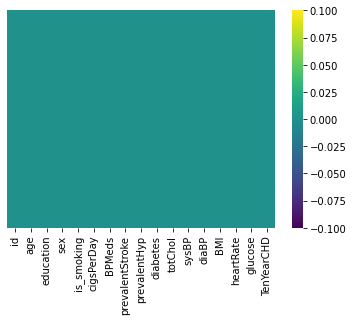

In [98]:
#Again checking null values 
sns.heatmap(data.isnull(), yticklabels=False, cmap="viridis")

In [99]:
##Rechecking if we have any missing value left
data.isnull().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [100]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [101]:
data.shape

(3368, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

## Exploratory Data Analysis

In [102]:
#Descriptive Stats

data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.00000,3368.000000,3368.000000,3368.000000,3368.000000
mean,49.543646,1.971200,9.069477,0.029691,0.006532,0.315914,0.025831,236.991686,132.601395,82.88465,25.796737,75.974762,81.692993,0.151425
std,8.603941,1.005805,11.879078,0.169759,0.080569,0.464948,0.158656,44.951744,22.300647,12.02176,4.114976,11.966154,23.198838,0.358516
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.00000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.50000,23.030000,68.000000,72.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.00000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.00000,28.025000,83.000000,85.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.50000,56.800000,143.000000,394.000000,1.000000


Observations :

Some the features are Discrete so let us analyze continuous ones

Age : We can see that Min. age of subject found in given records is 32 while Max. being 70. So our values are ranging from 32 to 70.

cigsPerDay : Subject smoking Cig. per day is as low as nill while we have 70 Cigs. per day making the Peak.

totChol : Min. Cholesterol level recorded in our dataset is 107 while Max. is 696.

sysBP : Min. Systolic Blood Pressure observed in Subject is 83 while Max. is 295.

diaBP : Min. Diastolic Blood Pressure observed in Subject is 48 while Max. is 142.

BMI : Body Mass Index in our dataset ranges from 15.96 to 56.80.

heartRate : Observed Heartrate in our case study is 44 to 143.

glucose : Glucose sugar level range is 40 to 394





Text(0.5, 1.0, 'CHD by Gender')

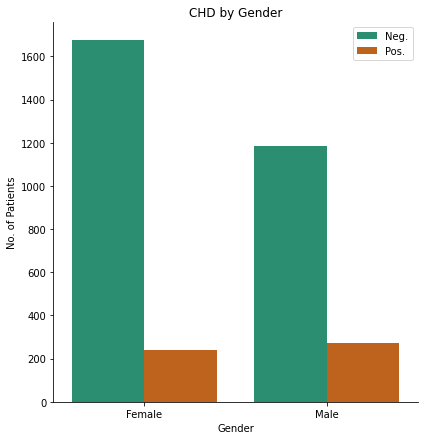

In [103]:
#CHD by Gender Viz.

sns.catplot(x='sex', hue='TenYearCHD', data=data, kind='count', palette='Dark2', height=6, legend=False)
plt.xlabel('Gender')
plt.xticks(ticks=[0,1], labels=['Female', 'Male'])
plt.ylabel('No. of Patients')
plt.legend(['Neg.', 'Pos.'])
plt.title('CHD by Gender')

Observations :

Above Bivariate Analysis plot depicts Gender wise absence / presence of Chronic Heart Disease (CHD).

Observations tells us that we've Excessive number of people who are not suffering from CHD.

Negative : Approx. 80 to 90% of Females are falling in Negative Category while Approx. 60 to 70% of Males are in Negative Slot.

Positive : While Approx. 10% of Females & Males are suffering from CHD.

By this we can say that our Dataset is Imbalanced where Approx. 80 to 90% are Negative Classifications and Approx. 10 to 15% are Positive Classes.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Agewise distribution of the patients')

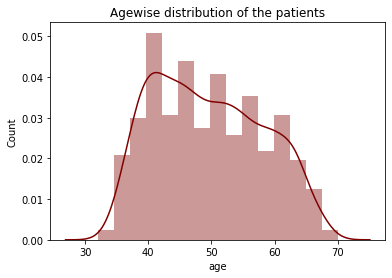

In [104]:
sns.displot(data['age'], bins=15, kde=True, color='maroon')
plt.ylabel('Count')
plt.title('Agewise distribution of the patients')

Observation :

Age ranging from 40 to 50 are in Majority followed by 50 to 70.

Let us define a user-defined Function to encode Age.

In [105]:
#User-defined function

#Age encoding
def encode_age(data):
    if data <= 40:
        return 0
    if data > 40 and data <=55:
        return 1
    else:
        return 2    

#heart rate encoder
def heartrate_enc(data):
    if data <= 60:
        return 0
    if data > 60 and data <=100:
        return 1
    else:
        return 2

#applying functions
data['enc_hr'] = data['heartRate'].apply(heartrate_enc)
data['encode_age'] = data['age'].apply(lambda x : encode_age(x))

Above Functions will Encode Age and Heart Rate.
We can encode the Age Group Further :

Subject with Age <= 40 are Adults.

Subject with Age > 40 and <= 55 are Middle-Aged Adult.

Subject Above 55 will fall in Senior Category.

We'll Encode HeartRate as follows:

HeartRate <= 60 is Low / Resting HeartBeat.

HeartRate between 60 to 100 is considered as Normal.

While, HeartRate above 100 is High.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count by Age Group')

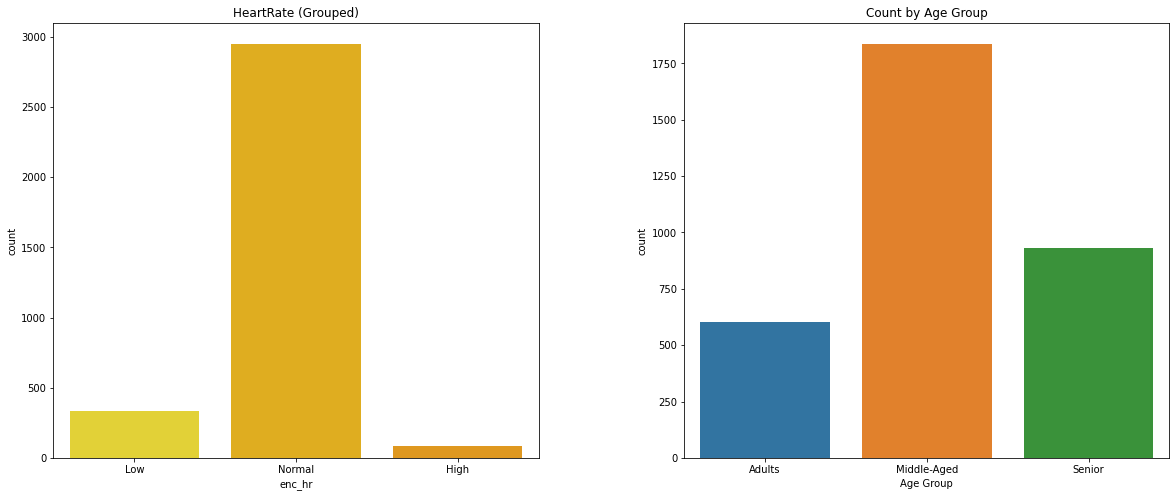

In [106]:
#HeartRate (Grouped) Count

plt.figure(figsize=(20,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(1, 2, 1)
sns.countplot(data['enc_hr'], palette='Wistia')
plt.title('HeartRate (Grouped)')
plt.xticks([0,1,2], ['Low', 'Normal', 'High'])

plt.subplot(1, 2, 2)
sns.countplot(data['encode_age'])
plt.xlabel('Age Group')
plt.xticks(ticks=[0,1,2], labels=['Adults', 'Middle-Aged', 'Senior'])
plt.title('Count by Age Group')


We can observe that Subject with Normal HeartRate are in Majority followed by 
Resting / Low HeartRate and High HeartRate.

We've more number of Middle-Aged Adults in our Dataset followed by Seniors And then Adults

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Cigs. per day by Age Group')

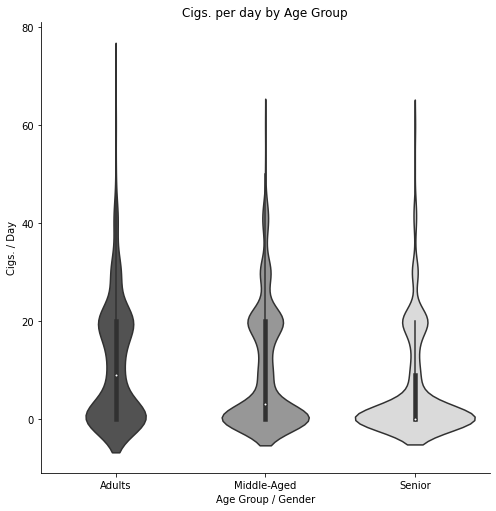

In [107]:
#Violin Plot of Cigsperday by age group

sns.catplot(data=data, x='encode_age', y='cigsPerDay', kind='violin', size=7, palette='Greys_r')
plt.xlabel('Age Group / Gender')
plt.ylabel('Cigs. / Day')
plt.xticks(ticks=[0,1,2], labels=['Adults', 'Middle-Aged', 'Senior'])
plt.title('Cigs. per day by Age Group')


Observation :

Adults : In Adults we can observe that Median values has Lower Kernel Density followed by 75% IQR's Density. While, 25% IQR marks the Higher Kernel Density.

Middle-Aged : In Middle-Aged Group we can observe that 25% IQR & Median has Higher Kernel Density while 75% IQR has a quite Lower Kernel Density.

Senior : In Seniority section we can observe that Median and 25% IQR are Closely Intact to each other having Higher Kernel Density, while 75% IQR got Lower Kernel Density.

Text(0.5, 1.0, 'Target Class Count')

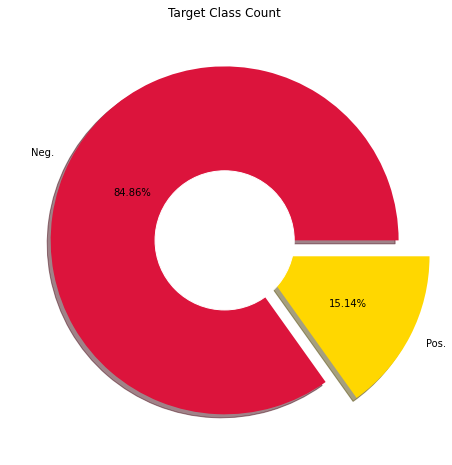

In [108]:
#Target Class count

plt.figure(figsize=(8,8))
plt.pie(data['TenYearCHD'].value_counts(), labels=['Neg.','Pos.'], autopct='%1.2f%%', explode=[0,0.2], shadow=True, colors=['crimson','gold'])
my_circle = plt.Circle( (0,0), 0.4, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Target Class Count')

Observations :

We can see that we've Imbalanced Dataset here having ratio of 85:15 where Positive Class is Minor.

We'll need to balance the Dataset in this case to get the best out of it.



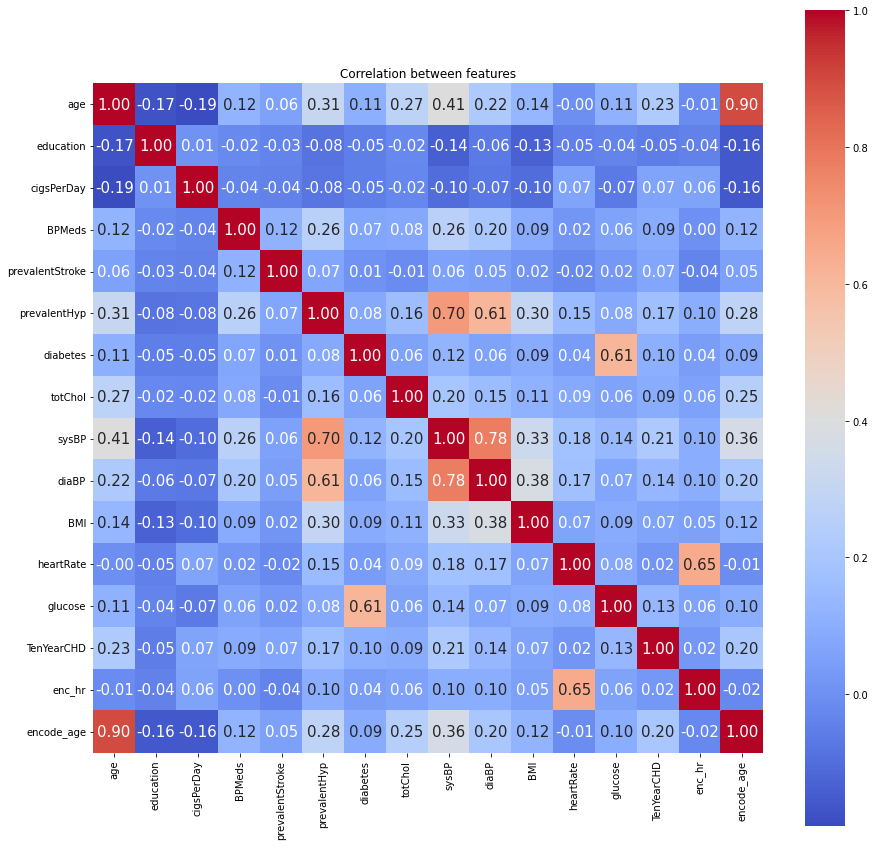

In [109]:
# Correlation
df_corr = data.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.title('Correlation between features');


###Observations :

Correlation plot gives us valuable information regarding Relation within Attributes. It can Either be Negative or Positive or Nill. We need to always keep 1 feature from 2 Strongly Correlated ones

currentSmoker & cigsPerDay has strong Correlation of 77

prevalentHyp vs sysBP / diaBP are having Positive Correlation of 70 and 61.

While, glucose & diabetes are postively Correlated.

sysBP & diaBP are also having Positive Correlation.

In [110]:
#We're dropping few features here because they are Positively Correlated (As we saw in Correlation Plot)
data.drop("is_smoking", axis=1, inplace=True)
data.drop("glucose", axis=1, inplace=True)
data.drop("sysBP", axis=1, inplace=True)
data.drop("prevalentHyp", axis=1, inplace=True)
data.drop("encode_age", axis=1, inplace=True)
data.drop("enc_hr", axis=1, inplace=True)
data.drop("education", axis=1, inplace=True)
data.head()

,age,sex,cigsPerDay,BPMeds,prevalentStroke,diabetes,totChol,diaBP,BMI,heartRate,TenYearCHD
0,64,F,3.0,0.0,0,0,221.0,85.0,25.38,90.0,1
1,36,M,0.0,0.0,0,0,212.0,98.0,29.77,72.0,0
2,46,F,10.0,0.0,0,0,250.0,71.0,20.35,88.0,0
3,50,M,20.0,0.0,0,0,233.0,88.0,28.26,68.0,1
4,64,F,30.0,0.0,0,0,241.0,85.0,26.42,70.0,0


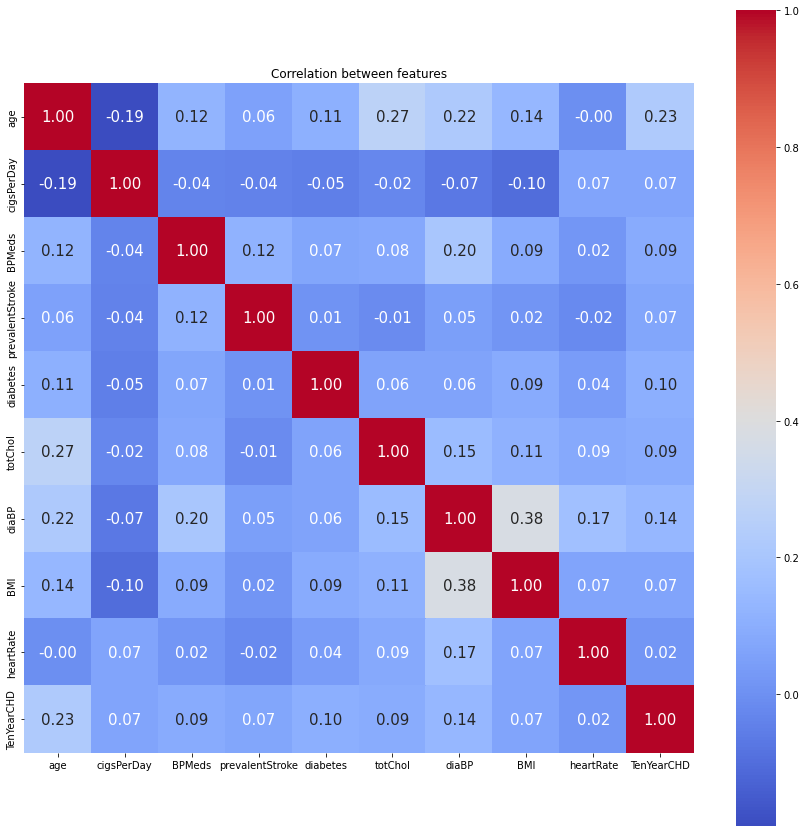

In [111]:
# Correlation
df_corr = data.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.title('Correlation between features');

##Dealing with object type variables 

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3389
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3368 non-null   int64  
 1   sex              3368 non-null   object 
 2   cigsPerDay       3368 non-null   float64
 3   BPMeds           3368 non-null   float64
 4   prevalentStroke  3368 non-null   int64  
 5   diabetes         3368 non-null   int64  
 6   totChol          3368 non-null   float64
 7   diaBP            3368 non-null   float64
 8   BMI              3368 non-null   float64
 9   heartRate        3368 non-null   float64
 10  TenYearCHD       3368 non-null   int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 475.8+ KB


In [113]:
## Encoding Assortment with numerical values
data['sex']=data['sex'].apply(lambda x: 1 if x=='M' else 0)
#data['is_smoking']=data['is_smoking'].apply(lambda x: 1 if x=='YES' else 0)

In [114]:
data.head()

,age,sex,cigsPerDay,BPMeds,prevalentStroke,diabetes,totChol,diaBP,BMI,heartRate,TenYearCHD
0,64,0,3.0,0.0,0,0,221.0,85.0,25.38,90.0,1
1,36,1,0.0,0.0,0,0,212.0,98.0,29.77,72.0,0
2,46,0,10.0,0.0,0,0,250.0,71.0,20.35,88.0,0
3,50,1,20.0,0.0,0,0,233.0,88.0,28.26,68.0,1
4,64,0,30.0,0.0,0,0,241.0,85.0,26.42,70.0,0


## Data prepation to modeling

In [115]:
data.columns

Index(['age', 'sex', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'diabetes',
       'totChol', 'diaBP', 'BMI', 'heartRate', 'TenYearCHD'],
      dtype='object')

Splitting target variable from independent variables

In [116]:
target_variable = 'TenYearCHD'
X = data.drop([target_variable], axis=1).values
y = data[target_variable].values

In [117]:
X

array([[ 64.  ,   0.  ,   3.  , ...,  85.  ,  25.38,  90.  ],
       [ 36.  ,   1.  ,   0.  , ...,  98.  ,  29.77,  72.  ],
       [ 46.  ,   0.  ,  10.  , ...,  71.  ,  20.35,  88.  ],
       ...,
       [ 44.  ,   1.  ,   3.  , ..., 119.  ,  28.92,  73.  ],
       [ 60.  ,   1.  ,   0.  , ..., 105.  ,  23.01,  80.  ],
       [ 54.  ,   0.  ,   0.  , ...,  77.  ,  29.88,  79.  ]])

In [118]:
y

array([1, 0, 0, ..., 1, 0, 0])

In [119]:
#Applying SMOTE
num_before = dict(Counter(y))
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X,y)

print('Original dataset shape', len(data))
print('Resampled dataset shape', len(y_smote))
num_after =dict(Counter(y_smote))

Original dataset shape 3368
Resampled dataset shape 5716


In [120]:
print(num_before, num_after)

{1: 510, 0: 2858} {1: 2858, 0: 2858}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


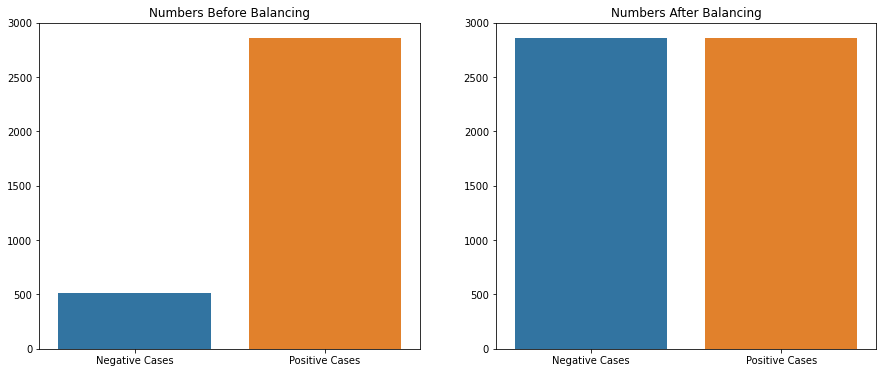

In [121]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(labels, list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(labels, list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

Splitting train and test data

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=0)

In [123]:
X_train

array([[5.93672701e+01, 9.03899786e-02, 1.54519499e+01, ...,
        1.01361560e+02, 2.37011602e+01, 9.18192200e+01],
       [5.17392293e+01, 1.00000000e+00, 1.50000000e+01, ...,
        7.60861653e+01, 2.44252609e+01, 6.36961467e+01],
       [4.20000000e+01, 0.00000000e+00, 3.00000000e+01, ...,
        6.70000000e+01, 2.42300000e+01, 7.20000000e+01],
       ...,
       [4.20000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        7.90000000e+01, 2.13100000e+01, 7.00000000e+01],
       [4.60000000e+01, 1.00000000e+00, 1.50000000e+01, ...,
        9.40000000e+01, 2.63100000e+01, 9.80000000e+01],
       [4.70000000e+01, 0.00000000e+00, 4.00000000e+01, ...,
        8.50000000e+01, 2.70500000e+01, 7.50000000e+01]])

In [124]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [125]:
X_test

array([[56.        ,  0.        ,  0.        , ..., 82.        ,
        26.82      , 80.        ],
       [38.56025969,  0.15602597, 21.56025969, ..., 74.35814283,
        22.41232854, 74.06384419],
       [36.        ,  1.        , 20.        , ..., 94.5       ,
        36.52      , 65.        ],
       ...,
       [57.        ,  1.        ,  0.        , ..., 78.        ,
        29.02      , 72.        ],
       [36.        ,  0.        ,  0.        , ..., 62.        ,
        20.79      , 75.        ],
       [50.11732623,  0.        ,  0.        , ..., 88.83799467,
        27.53436232, 71.39665779]])

In [126]:
y_test

array([0, 1, 0, ..., 0, 0, 1])

Feature Scaling X_train and X_test

In [127]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [128]:
X_train_scaled

array([[ 0.9335305 , -0.81053162,  0.47836848, ...,  1.3686927 ,
        -0.59167468,  1.36504246],
       [ 0.03101429,  1.11033922,  0.44134661, ..., -0.66226293,
        -0.40582548, -1.05013911],
       [-1.12128844, -1.00141285,  1.67008465, ..., -1.39236424,
        -0.45594155, -0.33701245],
       ...,
       [-1.12128844, -1.00141285, -0.78739143, ..., -0.42812736,
        -1.20539488, -0.50877046],
       [-0.64802605,  1.11033922,  0.44134661, ...,  0.77716874,
         0.07791562,  1.89584169],
       [-0.52971046, -1.00141285,  2.48924334, ...,  0.05399108,
         0.26784557, -0.07937543]])

In [129]:
X_test_scaled

array([[ 0.53512992, -1.00141285, -0.78739143, ..., -0.18706814,
         0.20881329,  0.3500196 ],
       [-1.52826337, -0.67192469,  0.97873598, ..., -0.80111485,
        -0.92246892, -0.15977156],
       [-1.83118203,  1.11033922,  0.85092595, ...,  0.81734528,
         2.69843567, -0.93816548],
       ...,
       [ 0.65344551,  1.11033922, -0.78739143, ..., -0.50848043,
         0.77346991, -0.33701245],
       [-1.83118203, -1.00141285, -0.78739143, ..., -1.7941296 ,
        -1.33885918, -0.07937543],
       [-0.16088214, -1.00141285, -0.78739143, ...,  0.36238575,
         0.39216302, -0.38882688]])

Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

##K-Nearest Neighbors (K-NN)

Training the K-NN model on the Training set

In [130]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Making the Confusion Matrix

In [131]:
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(528, 397, 181, 38)

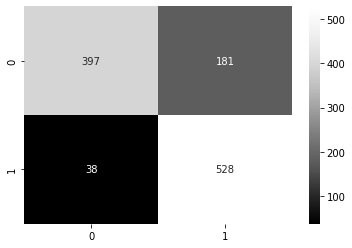

In [132]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Greys_r', fmt='d')


In [133]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_KNNClassifier)

0.8085664335664335


Calculating accuracy score

In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78       578
           1       0.74      0.93      0.83       566

    accuracy                           0.81      1144
   macro avg       0.83      0.81      0.81      1144
weighted avg       0.83      0.81      0.81      1144



#hyperparameter optimization

In [135]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np
grid_params = { 'n_neighbors' : [5,7,9,11,13],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

In [136]:
# fit the model on our train set
g_res = gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [137]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [138]:
# find the best score
g_res.best_score_


0.8462352476952327

In [139]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',metric = 'manhattan')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [140]:
# get a prediction
y_hat = knn.predict(X_train_scaled)
y_knn = knn.predict(X_test_scaled)

In [141]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_knn)
print(accuracy_score_KNNClassifier)

0.8618881118881119


In [142]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_knn).ravel()
tp, tn, fp, fn


(552, 434, 144, 14)

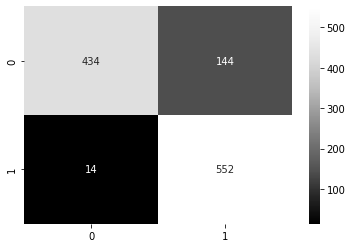

In [143]:
sns.heatmap(confusion_matrix(y_test,y_knn), annot=True, cmap='Greys_r', fmt='d')


In [144]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85       578
           1       0.79      0.98      0.87       566

    accuracy                           0.86      1144
   macro avg       0.88      0.86      0.86      1144
weighted avg       0.88      0.86      0.86      1144



In [145]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_knn)

0.7244029177136444

##Support Vector Machine (SVM)

Training the SVM model on the Training set

In [146]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

Making the Confusion Matrix

In [147]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(389, 352, 226, 177)

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Greys_r', fmt='d')


Calculating accuracy score

In [148]:
accuracy_score_SVM = accuracy_score(y_test, y_pred)
print(accuracy_score_SVM)

0.6477272727272727


Classification report

In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       578
           1       0.63      0.69      0.66       566

    accuracy                           0.65      1144
   macro avg       0.65      0.65      0.65      1144
weighted avg       0.65      0.65      0.65      1144



In [150]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train_scaled, y_train )

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.687 total time=   1.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.660 total time=   1.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.668 total time=   1.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   1.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.706 total time=   1.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.686 total time=   0.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.693 total time=   0.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.677 total time=   0.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.696 total time=   0.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.679 total time=   0.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.678 total time=   0.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [151]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [152]:
grid_predictions = grid.predict(X_test_scaled)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       578
           1       0.87      0.92      0.89       566

    accuracy                           0.89      1144
   macro avg       0.89      0.89      0.89      1144
weighted avg       0.89      0.89      0.89      1144



In [153]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, grid_predictions).ravel()
tp, tn, fp, fn

(518, 501, 77, 48)

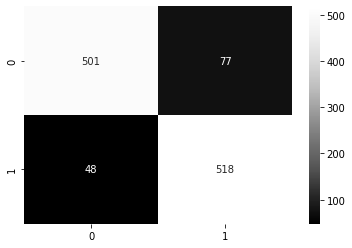

In [154]:
sns.heatmap(confusion_matrix(y_test,grid_predictions), annot=True, cmap='Greys_r', fmt='d')


In [155]:
accuracy_score_SVM = accuracy_score(y_test, grid_predictions)
print(accuracy_score_SVM)

0.8907342657342657


In [156]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, grid_predictions)

0.7815606650332089

##Accuracy Scores of each classification model are as follows 

In [157]:
print(f'''Accuracy Scores:
K Nearest Neigbours         : {accuracy_score_KNNClassifier}
Support Vector Machine      : {accuracy_score_SVM}
''')

Accuracy Scores:
K Nearest Neigbours         : 0.8618881118881119
Support Vector Machine      : 0.8907342657342657

